In [27]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
train_dir = 'D:\Rice\COMP 540/data/train_set/'
val_dir = 'D:\Rice\COMP 540/data/val_set/'
test_dir = 'D:\Rice\COMP 540/data/test_set/'
train_df = pd.read_csv('D:\Rice\COMP 540/data/train_labels.csv')
val_df = pd.read_csv('D:\Rice\COMP 540/data/val_labels.csv')
test_df = pd.read_csv('D:\Rice\COMP 540/data/sample_submission.csv')

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 32
size = (256, 256)

In [7]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                   directory=train_dir,
                                                   x_col='img_name',
                                                   y_col='label',
                                                   shuffle=True,
                                                   batch_size=batch_size,
                                                   target_size=size,
                                                   class_mode='input',
                                                   )
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                   directory=val_dir,
                                                   x_col='img_name',
                                                   y_col='label',
                                                   shuffle=False,
                                                   batch_size=batch_size,
                                                   target_size=size,
                                                   class_mode='input',
                                                   )

Found 118475 validated image filenames.
Found 11994 validated image filenames.


In [28]:
input_img = Input(shape=(256, 256, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((4, 4), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 8)         0         
_________

In [30]:
from keras.callbacks import TensorBoard

filepath       = "base-weights2.hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [32]:
history = autoencoder.fit_generator(train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                callbacks=callbacks_list,                                 
                                epochs=5)

Epoch 1/5
3703/3703 [==============================] - 9906s 3s/step - loss: 0.5573 - val_loss: 0.5447

Epoch 00001: val_loss improved from inf to 0.54471, saving model to base-weights2.hdf5
Epoch 2/5
3703/3703 [==============================] - 9911s 3s/step - loss: 0.5375 - val_loss: 0.5382

Epoch 00002: val_loss improved from 0.54471 to 0.53817, saving model to base-weights2.hdf5
Epoch 3/5
3703/3703 [==============================] - 9900s 3s/step - loss: 0.5332 - val_loss: 0.5341

Epoch 00003: val_loss improved from 0.53817 to 0.53406, saving model to base-weights2.hdf5
Epoch 4/5
3703/3703 [==============================] - 9895s 3s/step - loss: 0.5303 - val_loss: 0.5325

Epoch 00004: val_loss improved from 0.53406 to 0.53246, saving model to base-weights2.hdf5
Epoch 5/5
3703/3703 [==============================] - 9894s 3s/step - loss: 0.5284 - val_loss: 0.5337

Epoch 00005: val_loss did not improve from 0.53246


In [47]:
encoder = Model(input_img, autoencoder.layers[8].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 64, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 8)         0         
__________

In [55]:
def predict_generator(model, gen):
    # Predict latent-space map
    pred_maps = encoder.predict_generator(val_generator,steps = len(val_generator))
    # Predict latent-space vector
    pred_enb = pred_maps.reshape(val_df.shape[0], -1)
    return pred_enb

In [56]:
pred_enb = predict_generator(encoder, val_generator)
pred_enb.shape

(11994, 512)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plt_reduce_space(x, color=[]):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=color,
            alpha=.4, s=3**2, cmap='viridis')
    plt.show()

In [ ]:
# Reduce dimmension
enb_reduce = TSNE(n_components=2).fit_transform(pred_enb)

In [ ]:
plt_reduce_space(enb_reduce, df_val.label.values.astype(int))

In [ ]:
imgs      = train_generator.next()[0]
imgs_pred = autoencoder.predict(imgs)

In [57]:
def plot_images(imgs, imgs_pred):
    fig=plt.figure(figsize=(10, 20))
    columns = 2
    rows    = 8

    for i in range(1, 9, 2):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(imgs_pred[i])
    plt.show()
plot_images(imgs, imgs_pred)

NameError: name 'imgs' is not defined

In [ ]:
# train
train_enb = predict_generator(encoder, train_generator_inf)
df_emb_train = pd.DataFrame(train_enb)
df_emb_train['img_name'] = df_train.img_name.values

# Val
val_enb = pred_enb#predict_generator(encoder, test_generator)
df_emb_val = pd.DataFrame(val_enb)
df_emb_val['img_name'] = df_val.img_name.values

df_emb_train.shape, df_emb_val.shape

In [33]:
mymodel = load_model('base-weights2.hdf5')

In [36]:
from keras.utils import plot_model

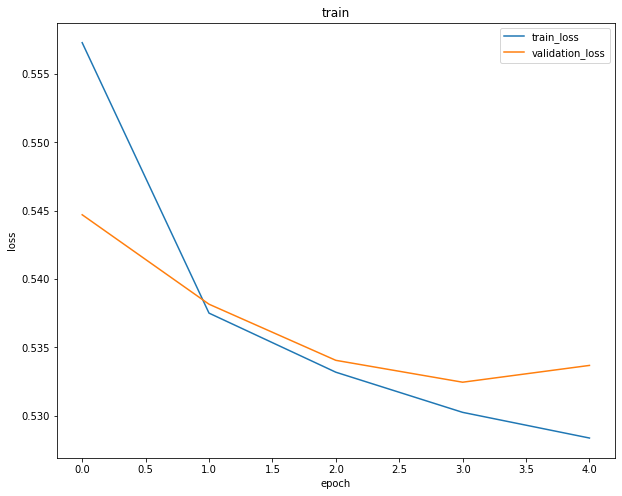

In [38]:
plt.title('train')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

In [44]:
def predict_class(model, images, show = True):
    for img in images:
        img = load_img(img, target_size=(256, 256, 3))
        img = img_to_array(img)                    
        img = np.expand_dims(img, axis=0)         
        img /= 255.                                      

        pred = model.predict(img)
        index = np.argmax(pred)
        if show:
            plt.imshow(img[0])                           
            plt.axis('off')
            plt.title(index)
            plt.show()

In [45]:
images = []
for i in range(5):
    images.append(os.path.join(test_dir, test_df.iloc[i]['img_name']))

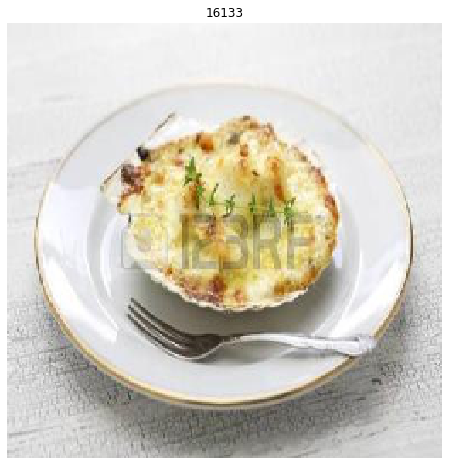

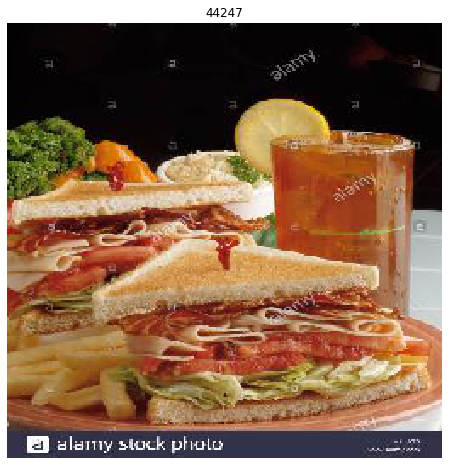

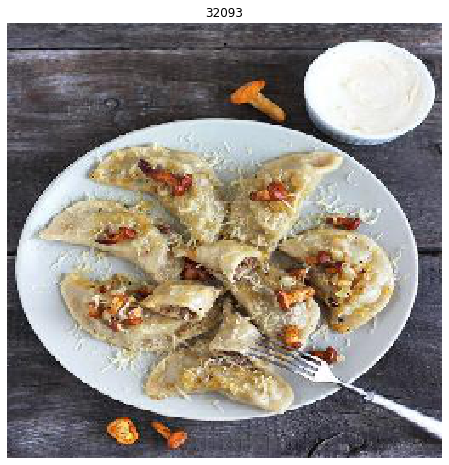

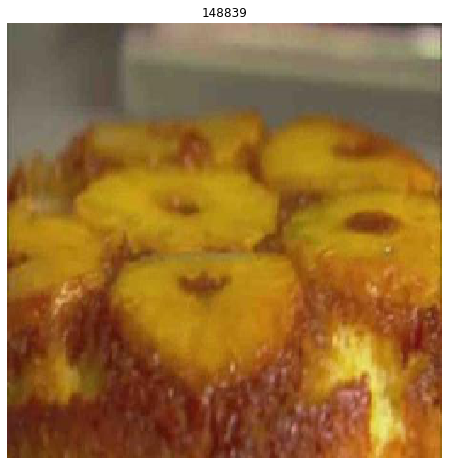

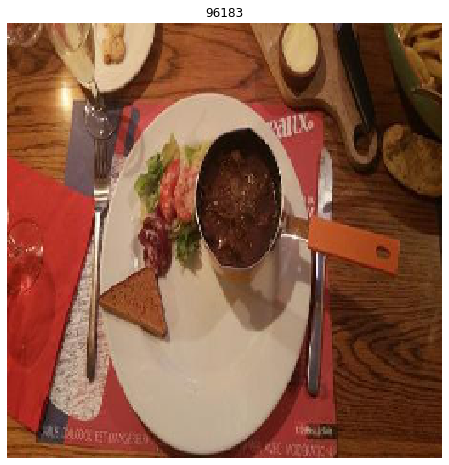

In [46]:
predict_class(mymodel, images)

In [37]:
plot_model(mymodel, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [13]:
inception = InceptionV3(weights='imagenet', include_top=False)









87916544/87910968 [==============================] - 13s 0us/step


In [17]:
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
predictions = Dense(251,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 

In [22]:
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = len(train_generator),
                    validation_data=val_generator,
                    validation_steps= len(val_generator),
                    epochs=15,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15


ValueError: Error when checking target: expected dense_3 to have 2 dimensions, but got array with shape (32, 256, 256, 3)

In [4]:
import datautils

In [5]:
from keras.datasets import cifar10

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
def load_data(df, dir, size=(256, 256, 3)):
    X = []
    y = []
    n = len(df)
    train = []
    for i in range(n):
        img_name = df.iloc[i]['img_name']
        label_name = df.iloc[i]['label']
        y.append(label_name)
        image = load_img(os.path.join(dir, img_name), color_mode='rgb', target_size=size)
        image = img_to_array(image)
        image = image.reshape((1, -1))
        train.append(np.squeeze(image))
    X.append(train)
    X = np.array(X)
    X = X.reshape((-1, X.shape[2]))
    y = np.array(y).reshape(-1, 1)
    return X, y

In [5]:
Xtrain, ytrain = load_data(train_df, train_dir)


KeyboardInterrupt



In [6]:
Xtrain.shape, ytrain.shape

NameError: name 'Xtrain' is not defined

In [ ]:
X, y = [], []

In [6]:
n = len(train_df)
for i in range(n):
    

11994

In [7]:
size=(256, 256, 3)

In [8]:
for i in range(n):
    img_name = val_df.iloc[i]['img_name']
    label_name = val_df.iloc[i]['label']
    y.append(label_name)
    image = load_img(os.path.join(val_dir, img_name), color_mode='rgb', target_size=size)
    image = img_to_array(image)
    image = image.reshape((1, -1))
    train.append(np.squeeze(image))

In [11]:
X.append(train)
X = np.array(X)
X = X.reshape((-1, X.shape[2]))
y = np.array(y).reshape(-1, )

In [14]:
len(train)

11994

In [13]:
X.shape, y.shape

((23988, 196608), (11994,))

In [ ]:
X

In [ ]:
y